# Cats vs dogs kaggle competition
### Using VGG16 and VGG19 with bottleneck features
#### This is largely based in this article https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html and http://www.codesofinterest.com/2017/08/bottleneck-features-multi-class-classification-keras.html

First, note that we will expect datato be in this format 

```
├── real_test
│   ├── 10111.jpg
│   ├── 8111.jpg
│   └── 9111.jpg
├── test
│   ├── cat
│   │   └── cat.4111.jpg
│   └── dog
│       ├── dog.1111.jpg
│       └── dog.2111.jpg
├── train
│   ├── cat
│   │   ├── cat.10111.jpg
│   │   ├── cat.11111.jpg
│   │   ├── cat.1111.jpg
│   └── dog
│       ├── dog.10111.jpg
│       ├── dog.111.jpg
└── validation
    ├── cat
    │   ├── cat.5111.jpg
    │   └── cat.7111.jpg
    └── dog
        ├── dog.11111.jpg
        └── dog.12111.jpg
        ```


In [1]:
# Lets import some stuff
import tensorflow as tf
from skimage import io
from IPython.display import Image
from PIL import Image as PILImage
import pandas as pd

#from skimage.transform import resize
import matplotlib.pyplot as plt
from os import listdir
from os import mkdir
from skimage.io import imsave
import numpy as np
from sklearn.utils import shuffle
import sys
#import os
import cv2
import os.path

from keras.models import Sequential
from keras.applications import vgg16, vgg19
from keras.layers import Dense, GlobalAveragePooling2D, Dropout, Flatten
from keras.models import Model
from keras.initializers import TruncatedNormal
from keras import optimizers
from keras.models import load_model
from keras.callbacks import EarlyStopping, TensorBoard
from keras.preprocessing.image import ImageDataGenerator
from keras.utils.np_utils import to_categorical  


%matplotlib inline

Using TensorFlow backend.


In [2]:
IMAGE_WIDTH = 224
IMAGE_HEIGHT = 224

FLOYDHUB=True
if FLOYDHUB:
    OUTPUT_DIR = "/output/"
    DATA_DIR = "/input/"
    CLEANED_DATA_DIR = "/input/"
    CATS_DIR = "/input/train/cat/"
else:
    CATS_DIR = "data/train/"
    OUTPUT_DIR = "/tmp/"
    DATA_DIR = "data/"
    CLEANED_DATA_DIR = "data/cleaned/"

In [3]:
batch_size = 16

# this is the augmentation configuration we will use for training
train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)

# this is the augmentation configuration we will use for validation:
# only rescaling
validation_datagen = ImageDataGenerator(rescale=1./255)

# and the same for the test set
test_datagen = ImageDataGenerator(rescale=1./255)

# this is a generator that will read pictures found in
# subfolers of 'data/train', and indefinitely generate
# batches of augmented image data
train_generator = train_datagen.flow_from_directory(
        CLEANED_DATA_DIR + '/train',  # this is the target directory
        target_size=(IMAGE_WIDTH, IMAGE_HEIGHT),  # all images will be resized to 150x150
        batch_size=batch_size,
        shuffle=False,
        class_mode=None)  # this means our generator will only yield batches of data, no labels

# this is a similar generator, for validation data
validation_generator = validation_datagen.flow_from_directory(
        CLEANED_DATA_DIR + '/validation',
        target_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
        batch_size=batch_size,
        shuffle=False,
        class_mode=None)

# And the generator for test data
test_generator = test_datagen.flow_from_directory(
        CLEANED_DATA_DIR + '/test',
        target_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
        batch_size=batch_size,
        shuffle=False,
        class_mode=None)

Found 19999 images belonging to 2 classes.
Found 2500 images belonging to 2 classes.
Found 2501 images belonging to 2 classes.


In [4]:
training_samples = 19984 # Remember, we use 80% of 25k images, so 25000 * 0.8 = 20000
validation_samples = 2496 # Remember we use 10% of 25k images so 25000 * 0.1 = 2500

test_samples = 2496
total_steps = test_samples // batch_size

#training_samples = batch_size*300 # Remember, we use 80% of 25k images, so 25000 * 0.8 = 20000
#validation_samples = batch_size*150 # Remember we use 10% of 25k images so 25000 * 0.1 = 2500

### We need a couple of callbacks for our models, one to perform early stopping, the other for tensorboard info

In [5]:
early_stopping=EarlyStopping(monitor='val_loss', 
                             min_delta=0.001, 
                             patience=3, 
                             verbose=1, 
                             mode='auto')

tensorboard = TensorBoard(log_dir='./tensorboard-logs', 
                          histogram_freq=0, 
                          write_graph=True, 
                          write_images=True)

In [6]:
model_vgg16 = vgg16.VGG16(include_top=False, weights='imagenet')

In [7]:
model_vgg16.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, None, None, 3)     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0         
__________

In [8]:
bottleneck_features_train = model_vgg16.predict_generator(train_generator, 
                                                          training_samples // batch_size, 
                                                          verbose=1)

1249/1249 [==============================] - 238s   


In [9]:
np.save(OUTPUT_DIR+'bottleneck_features_train.npy', bottleneck_features_train)

In [10]:
bottleneck_features_train.shape

(19984, 7, 7, 512)

In [11]:
bottleneck_features_validation = model_vgg16.predict_generator(validation_generator, 
                                                               validation_samples // batch_size,
                                                               verbose=1)

156/156 [==============================] - 28s    


In [12]:
np.save(OUTPUT_DIR+'bottleneck_features_validation.npy', bottleneck_features_validation)

In [13]:
bottleneck_features_validation.shape

(2496, 7, 7, 512)

### Now we load the bottleneck features

In [14]:
train_data_bottleneck = np.load(OUTPUT_DIR+'bottleneck_features_train.npy')
validation_data_bottleneck = np.load(OUTPUT_DIR+'bottleneck_features_validation.npy')

print(train_data_bottleneck.shape)
print(validation_data_bottleneck.shape)

(19984, 7, 7, 512)
(2496, 7, 7, 512)


#### We also need to get the labels for the features we have loaded... and we need to make sure we get them in the same order

In [28]:
# This is the same as the train generator... but it will have the classes too.
train_generator_classes = train_datagen.flow_from_directory(
                            CLEANED_DATA_DIR + '/train',  # this is the target directory
                            target_size=(IMAGE_WIDTH, IMAGE_HEIGHT),  # all images will be resized to 150x150
                            batch_size=batch_size,
                            shuffle=False,
                            class_mode='categorical')  # since we use categorical_crossentropy loss, 
                                                       # we will need one-hot-encoded...
    
# This is the same as the validation generator... but it will have the classes too
validation_generator_classes = validation_datagen.flow_from_directory(
                            CLEANED_DATA_DIR + '/validation',
                            target_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
                            batch_size=batch_size,
                            shuffle=False,
                            class_mode='categorical')  # since we use categorical_crossentropy loss, 
                                                       # we will need one-hot-encoded...    

Found 19999 images belonging to 2 classes.
Found 2500 images belonging to 2 classes.


Remember, we used variables
* training_samples
* validation_samples

before to determine how many images will be for training/validation, lets use the same ones to restore the labels

This is a bit non-direct, but here's how it works. Essentially we will iterate over the train_generator_classes variable a total of

```python
training_samples // batch_size
```

And the same will be done with the validation_generator_classes, that will yield us X and y elements, we can then use the y element in conjunction with ```classes``` and ```class_indices``` attributes to build a numpy array with the correct labels

Also, regarding how the array is constructed, you REALLY want to check this http://akuederle.com/create-numpy-array-with-for-loop

In [16]:
num_classes = 2
print("train_data_bottleneck shape is ", train_data_bottleneck.shape)
train_labels = np.empty((0, num_classes))
total_iterations = training_samples // batch_size
for x, y in train_generator_classes:
    train_labels = np.append(train_labels, y, axis=0)
    total_iterations-=1
    if total_iterations % 100 == 0:
        print(total_iterations, "to go")
    if total_iterations == 0:
        break
        
print("train_labels shape is", train_labels.shape)


print("validation_data_bottleneck shape is ", validation_data_bottleneck.shape)
validation_labels = np.empty((0, num_classes))
total_iterations = validation_samples // batch_size
for x, y in validation_generator_classes:
    validation_labels = np.append(validation_labels, y, axis=0)
    total_iterations-=1
    if total_iterations % 100 == 0:
        print(total_iterations, "to go")
    if total_iterations == 0:
        break
        
print("validation_labels shape is", validation_labels.shape)


train_data_bottleneck shape is  (19984, 7, 7, 512)
1200 to go
1100 to go
1000 to go
900 to go
800 to go
700 to go
600 to go
500 to go
400 to go
300 to go
200 to go
100 to go
0 to go
train_labels shape is (19984, 2)
validation_data_bottleneck shape is  (2496, 7, 7, 512)
100 to go
0 to go
validation_labels shape is (2496, 2)


In [29]:
model = Sequential()
model.add(Flatten(input_shape=train_data_bottleneck.shape[1:]))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()


#model.save_weights('bottleneck_fc_model.h5')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_3 (Flatten)          (None, 25088)             0         
_________________________________________________________________
dense_5 (Dense)              (None, 256)               6422784   
_________________________________________________________________
dropout_3 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 2)                 514       
Total params: 6,423,298
Trainable params: 6,423,298
Non-trainable params: 0
_________________________________________________________________


In [30]:
model_history = model.fit(train_data_bottleneck, train_labels,
                          epochs=25,
                          batch_size=batch_size,
                          callbacks=[early_stopping, tensorboard],
                          validation_data=(validation_data_bottleneck, validation_labels))

Train on 19984 samples, validate on 2496 samples
Epoch 1/25
19984/19984 [==============================] - 12s - loss: 0.5213 - acc: 0.8217 - val_loss: 0.2224 - val_acc: 0.9058
Epoch 2/25
19984/19984 [==============================] - 12s - loss: 0.3198 - acc: 0.8739 - val_loss: 0.2107 - val_acc: 0.9255
Epoch 3/25
19984/19984 [==============================] - 12s - loss: 0.2777 - acc: 0.8938 - val_loss: 0.2064 - val_acc: 0.9247
Epoch 4/25
19984/19984 [==============================] - 12s - loss: 0.2709 - acc: 0.8975 - val_loss: 0.2571 - val_acc: 0.9083
Epoch 5/25
19984/19984 [==============================] - 12s - loss: 0.2566 - acc: 0.9067 - val_loss: 0.2653 - val_acc: 0.9038
Epoch 6/25
19984/19984 [==============================] - 12s - loss: 0.2553 - acc: 0.9075 - val_loss: 0.2163 - val_acc: 0.9255
Epoch 7/25
19984/19984 [==============================] - 12s - loss: 0.2506 - acc: 0.9126 - val_loss: 0.2358 - val_acc: 0.9123
Epoch 00006: early stopping


In [31]:
def plot_learning_curves(history):
    h = pd.DataFrame([history.history['loss'], history.history['val_loss']])
    h = h.T
    h.columns=['acc', 'val_acc']
    h.plot(figsize=(20, 5))
    plt.show()

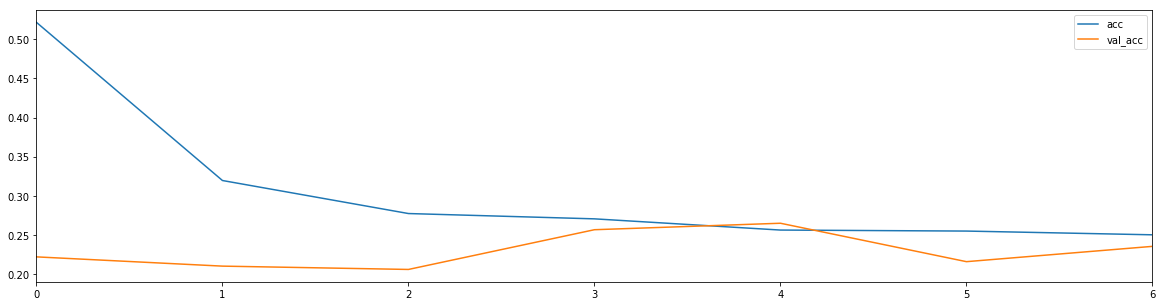

In [32]:
plot_learning_curves(model_history)

In [35]:
model.save_weights(OUTPUT_DIR + 'bottleneck_fc_model.h5')